# Accessing Fieldmaps admin bounds via GeoParquet

This notebook is exploring options for accessing admin bounds from Fieldmaps via the new [GeoParquet](https://geoparquet.org/) format.
This provides the opportunity for direct, in memory access to geospatial boundaries in Python, without the need to store local copies of Shapefiles (as is currently our practice).

For example, let's imagine that we want to access Nigeria's admin 1 level bounds. How might this work?


In [11]:
GLOBAL_ADM0 = "https://data.fieldmaps.io/adm0/osm/intl/adm0_polygons.parquet"
GLOBAL_ADM1 = "https://data.fieldmaps.io/edge-matched/humanitarian/intl/adm1_polygons.parquet"
ISO3 = "NGA"

# Option A: Direct GeoPandas

This option doesn't seem to work...


In [12]:
# Adapted from https://guide.cloudnativegeo.org/geoparquet/geoparquet-example.html

import geopandas as gpd
from fsspec.implementations.http import HTTPFileSystem

filesystem = HTTPFileSystem()
filters = [("iso_3", "=", ISO3)]
gdf = gpd.read_parquet(GLOBAL_ADM1, filesystem=filesystem, filters=filters)


<Axes: >

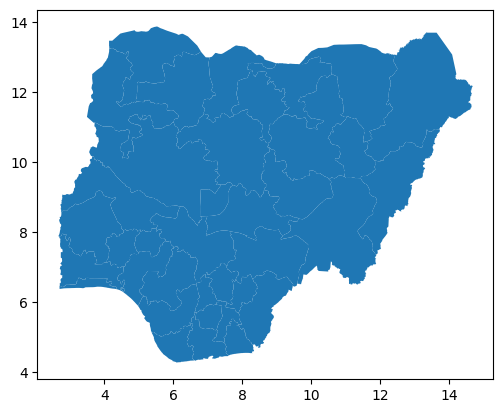

In [13]:
gdf.plot()

# Option B: Duckdb

Definitely more promising... This takes ~7s to load in all Admin 1 boundaries for Nigeria. Would it be feasible to replace
all admin bounds access with some code like this?

Resources:

- https://blobs.duckdb.org/papers/duckdb-spatial-geopython-2024.pdf
- https://ibis-project.org/posts/ibis-duckdb-geospatial/


In [14]:
from duckdb import connect

with connect() as con:
    result = con.sql(f"""
        LOAD spatial;
        SELECT
            adm1_id, adm1_name,
            ST_AsText(geometry) as geometry_wkt,
        FROM '{GLOBAL_ADM1}'
        WHERE iso_3 = '{ISO3}'
    """).df()

gdf = gpd.GeoDataFrame(
    result, geometry=gpd.GeoSeries.from_wkt(result["geometry_wkt"])
).drop("geometry_wkt", axis=1)

<Axes: >

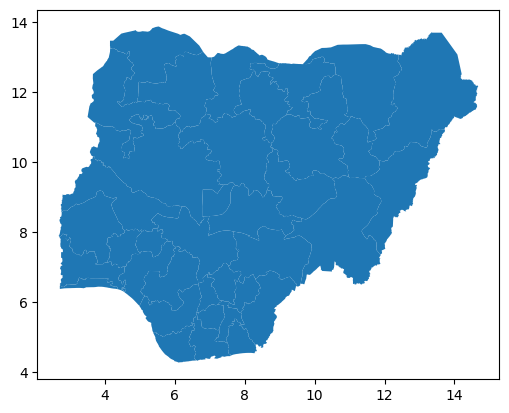

In [15]:
gdf.plot()